In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


In [19]:
# Extended from the below link: 
# https://github.com/ani1cr7/Stock-Price-Prediction-using-LSTM-Neural-Networks/blob/master/
# Stock%2BMarket%2BPrediction%2BWorking%2Band%2BExecution%2B.ipynb

import matplotlib.pyplot as plt 
import math
import keras 
from keras import optimizers
from keras.models import Sequential, load_model 
from keras.layers.core import Dense, Dropout, Activation 
from keras.layers.recurrent import SimpleRNN
import tensorflow as tf
import sklearn
from sklearn import preprocessing 
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
# get the data
df = pd.read_csv("/kaggle/input/nyse/prices-split-adjusted.csv", index_col = 0)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [21]:
# move close to the last column  
df["new close"] = df.close 
df.head()

,symbol,open,close,low,high,volume,new close
date,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,114.970001


In [22]:
# drop the close value for the stocks and show the data again
df = df.drop(columns='close')
df.head()

,symbol,open,low,high,volume,new close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [23]:
# choose one stock 
symbols = list(set(df.symbol))
df = df[df.symbol == 'NFLX'] 
df.head()

,symbol,open,low,high,volume,new close
date,,,,,,
2010-01-04,NFLX,7.931428,7.565714,7.961429,17239600.0,7.640000
2010-01-05,NFLX,7.652857,7.258572,7.657143,23753100.0,7.358572
2010-01-06,NFLX,7.361429,7.197143,7.672857,23290400.0,7.617143
2010-01-07,NFLX,7.731429,7.462857,7.757143,9955400.0,7.485714
2010-01-08,NFLX,7.498571,7.465714,7.742857,8180900.0,7.614286


In [24]:
# drop the column symbol 
df = df.drop(columns='symbol')
df.head()

,open,low,high,volume,new close
date,,,,,
2010-01-04,7.931428,7.565714,7.961429,17239600.0,7.640000
2010-01-05,7.652857,7.258572,7.657143,23753100.0,7.358572
2010-01-06,7.361429,7.197143,7.672857,23290400.0,7.617143
2010-01-07,7.731429,7.462857,7.757143,9955400.0,7.485714
2010-01-08,7.498571,7.465714,7.742857,8180900.0,7.614286


In [25]:
'''This function is for normalizating the data.'''
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler() 
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['new close'] = min_max_scaler.fit_transform(df['new close'].values.reshape(-1,1))
    return df 

# normalize the data
df=normalize_data(df)
df.head() 

,open,low,high,volume,new close
date,,,,,
2010-01-04,0.007820,0.005310,0.006209,0.049768,0.005015
2010-01-05,0.005577,0.002739,0.003795,0.070516,0.002744
2010-01-06,0.003231,0.002224,0.003920,0.069042,0.004831
2010-01-07,0.006210,0.004449,0.004589,0.026564,0.003770
2010-01-08,0.004335,0.004473,0.004475,0.020911,0.004808


In [26]:
'''This function is loading the data and choose 80% of data to be training data,
and rest to be testing dataset.'''
def load_data(stock, seq_len):
    num_of_features = len(stock.columns)
    data = stock.to_numpy()
    sequence_length = seq_len + 1 # index starting from 0 
    
    result = []
    
    for index in range(len(data) - sequence_length): # maximum date = latest date - sequence length 
        result.append(data[index: index + sequence_length]) # index: index + 22days
    
    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    train = result[:int(row), :]
    
    x_train = train[:, :-1] # all rows, all columns except last one 
    y_train = train[:, -1][:, -1]

    x_test = result[int(row):, :-1] # all rows, all but last one column
    y_test = result[int(row):, -1][:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_of_features))

    return [x_train, y_train, x_test, y_test] # return datasets

In [27]:
# set the sequence length to 22, since there are 22 days a month for stock market to open
seq_len = 22 
X_train, y_train, X_test, y_test = load_data(df, seq_len)
# print the size of training data and testing data
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (1391, 22, 5)
y_train.shape =  (1391,)
X_test.shape =  (348, 22, 5)
y_test.shape =  (348,)


In [28]:
'''This function is building the RNN model.'''
def build_model(layers):
    model = Sequential () 
    
    model.add(SimpleRNN(64, input_shape=(layers[1], layers[0]), return_sequences=False)) # one simple RNN layer
    model.add(Dropout(0.2)) 
    model.add(Dense(1,kernel_initializer='random_normal', activation = 'linear')) # initial weights randomly
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.0005) # reset the optimizer
    model.compile(optimizer=adam,loss='mse',metrics=['MeanAbsoluteError']) # using mean absolute error
    
    return model 

In [29]:
model = build_model([5,seq_len,1]) # stock open for 5 days a week and approximate 22 days a month
model.fit(X_train, y_train, batch_size=128, epochs=20,verbose=1) # fit the model

Epoch 1/20
11/11 [==============================] - 1s 14ms/step - loss: 0.0443 - mean_absolute_error: 0.1386
Epoch 2/20
11/11 [==============================] - 0s 15ms/step - loss: 0.0085 - mean_absolute_error: 0.0631
Epoch 3/20
11/11 [==============================] - 0s 15ms/step - loss: 0.0051 - mean_absolute_error: 0.0494
Epoch 4/20
11/11 [==============================] - 0s 15ms/step - loss: 0.0034 - mean_absolute_error: 0.0407
Epoch 5/20
11/11 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_absolute_error: 0.0371
Epoch 6/20
11/11 [==============================] - 0s 18ms/step - loss: 0.0026 - mean_absolute_error: 0.0352
Epoch 7/20
11/11 [==============================] - 0s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0345
Epoch 8/20
11/11 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_absolute_error: 0.0328
Epoch 9/20
11/11 [==============================] - 0s 15ms/step - loss: 0.0022 - mean_absolute_error: 0.0327
Epoch 10/2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 64)                4480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


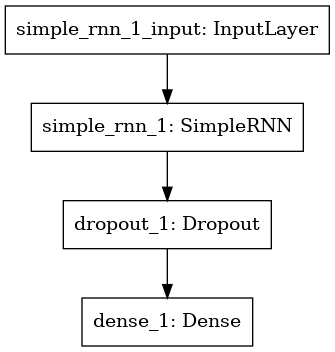

In [30]:
# show the architecture and structure of the model
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model) 

In [31]:
# use predict function to get predicted value y_pred for testing dataset
y_pred = model.predict(X_test)
print('y_pred.shape = ',y_pred.shape)

y_pred.shape =  (348, 1)


In [32]:
# calculate the overall MAE and MSE for testing dataset
mae_error = mean_absolute_error(y_test, y_pred)
print("MAE for test data: \n", mae_error)
mse_error = mean_squared_error(y_test, y_pred)
print("MSE for test data: \n", mse_error)

MAE for test data: 
 0.03931689172302768
MSE for test data: 
 0.0026562022853441948


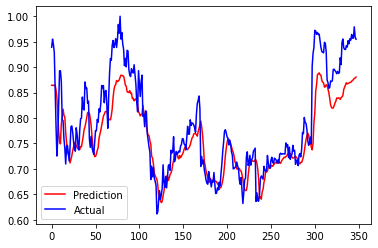

In [33]:
# show the plot for testing data, which matches well
plt.plot(y_pred,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.show()

In [34]:
'''This function is evaluating and showing the MSE and RMSE for training data and testing data. '''
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0] 

# the result is used for comparsion between this model and published state-of-art. 
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00040 MSE (0.02 RMSE)
Test Score: 0.00266 MSE (0.05 RMSE)


(0.0004001531342510134, 0.002656202297657728)